In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd
import json

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Rappel du sujet

- 15 actifs min et 40 max
- chaque actif ne doit pas etre superieux a 10% du portefeuille

# Manager API

In [130]:

class RESTManager:
    HOST_NAME = "dolphin.jump-technology.com"
    PORT = "8443"

    URL = "https://" + HOST_NAME + ":" + PORT + "/api/v1/"

    USERNAME_USER1 = "EPITA_GROUPE8"
    PASSWORD_USER1 = "AgLyQx64Jw6pAkW9"

    auth = (USERNAME_USER1, PASSWORD_USER1)


    def get(self, path):
        return requests.get(self.URL+path, auth=self.auth, verify=False).text
    
    def put(self, path, data):
        return requests.put(self.URL+path, auth=self.auth, data=data, verify=False)
    
    def post(self, path, data):
        return requests.post(self.URL+path, auth=self.auth, data=data, verify=False)
    
    def get_asset(self):
        dt_text = self.get("asset?columns=ASSET_DATABASE_ID&columns=LABEL&columns=TYPE&columns=LAST_CLOSE_VALUE_IN_CURR&columns=CURRENCY&date=2016-06-01")
        dt = json.loads(dt_text)
        df = []
        for i in range(len(dt)):
            tmp = {}
            for key in dt[i]:
                tmp[key] = dt[i][key]["value"]
            df.append(tmp)
        df = pd.DataFrame(df)
        return df
    
    def get_asset_id(self, uid):
        dt_text = self.get(f"asset/{uid}")
        dt = json.loads(dt_text)
        df={}
        for key in dt:
            df[key] = dt[key]["value"]
        #df = pd.DataFrame(df)
        return df
    
    def get_asset_id_quote(self, uid):
        dt_text = self.get(f"asset/{uid}/quote")
        dt = json.loads(dt_text)
        df = []
        for i in range(len(dt)):
            tmp = {}
            for key in dt[i]:
                tmp[key] = dt[i][key]["value"]
            df.append(tmp)
        df = pd.DataFrame(df)
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        #l = ["ask" ,"asset" ,"bid" ,"close" ,"feed_source" ,"gross" ,"high" ,"low","nav" ,"open", "pl" ,"real_close_price" ,"return" ,"volume"]
        l = ["return","nav"]
        for elt in l:
            df[elt] = df[elt].str.replace(',', '.').astype(float)
        return df
    
    def get_ratio(self):
        self.get("ratio")
    
    def sharpe(self, df, taux_sans_risque, periode=30):
        df['Log_Ret'] = np.log(df['close'] / df['close'].shift(1))
        df['Volatility'] = df['Log_Ret'].rolling(window=periode).std() * np.sqrt(periode)
        sharpe = (df["return"] - taux_sans_risque["1 mois"])/df["Volatility"]
        return sharpe
    
    def get_portfolio(self):
        resp = self.get("portfolio/1827/dyn_amount_compo")
        return resp

    def push(self, data):
        return self.put("portfolio/1827/dyn_amount_compo", data)
    
    def get_ratios(self, ref=False):
        data = {
            "ratio": [9, 12, 10],
            "asset": [1827, 2201],
            "start_date": "2016-06-01",
            "end_date": "2020-09-30",
            "frequency": "daily"
        }
        return self.post("ratio/invoke", json.dumps(data)).text
    
    def change_currency(self, c_in, c_out):
        url = f"currency/rate/{c_in}/to/{c_out}?date=2016-06-01"
        js = json.loads(self.get(url))["rate"]["value"].replace(",", ".")
        return float(js)
        

req = RESTManager()

In [123]:
l = [i + 1820 for i in range(13)]
l

[1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832]

In [287]:
df_asset = req.get_asset()
df_asset.loc[df_asset["ASSET_DATABASE_ID"] == "1590"]

,ASSET_DATABASE_ID,CURRENCY,LABEL,LAST_CLOSE_VALUE_IN_CURR,TYPE
387,1590,EUR,JPMorgan Funds - Europe Dynamic Fund I (acc),"25,8 EUR",FUND


In [292]:
test = req.get_asset_id_quote("1858") 
time2 = dt.datetime.strptime('2016-06-01', '%Y-%m-%d')
sdf2 = (test.index == time2) 
test.loc[sdf2]

,ask,asset,bid,close,feed_source,gross,high,low,nav,open,pl,real_close_price,return,volume
date,,,,,,,,,,,,,,
2016-06-01,"36,3",1858,"36,245","36,29",-10,"36,29","36,405",36,36.29,"36,255","-0,065","36,29",-0.001788,428852


# Optimisation de portefeuille

In [5]:
def sharpe(w,mat_return):
    mat_cov = np.cov(mat_return)# * mat_return.shape[1]


    if w.ndim != 1:
        variance = []
        for i in range(w.shape[0]):
            variance.append(w[i] @ mat_cov @ w[i].T)
    else:
        variance = w @ mat_cov @ w.T
        
    variance = np.array(variance)
    std = np.sqrt(variance)
    average_rend = mat_return.mean(axis=1)
    
    return (variance, std, average_rend@w.T)


# rendement & volatilité

Commençons par calculer la volatilité et le rendement de chaque actif pour pouvoir etablir un classement.

## 1) Récuperation des rendements

In [6]:
list_id = df_asset["ASSET_DATABASE_ID"].values
l_id = []

#Pour avoir l'index
a = req.get_asset_id_quote(list_id[0])[["return"]]
list_return = pd.DataFrame(index=a.index)
list_nav = pd.DataFrame(index=a.index)


for elt in list_id:
    if elt != "1827" and elt != "1867":
        try:
            df_tmp = req.get_asset_id_quote(elt)
            list_return[elt] = df_tmp["return"]
            list_nav[elt] = df_tmp["nav"]
            l_id.append(elt)
        except:
            pass
l_id = np.array(l_id)
list_nav = list_nav.fillna(method='ffill')

In [7]:
print(l_id.shape)
print(list_return.shape)

(471,)
(1898, 471)


on veut le rendement sur 2016-06-01 jusqu'a 2020-09-30

In [8]:
import datetime as dt
start = dt.datetime.strptime('2016-06-01', '%Y-%m-%d')
end = dt.datetime.strptime('2020-09-30', '%Y-%m-%d')
sdf = (list_return.index > start) & (list_return.index < end)

l_return = list_return.loc[sdf]
l_return = l_return.fillna(0)

## 2) Classement

In [9]:
rend_l = l_return.values.mean(axis=0)
std_l = l_return.values.std(axis=0)
rend_l.shape

(471,)

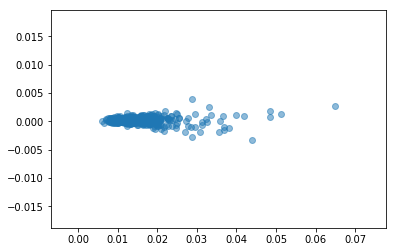

In [10]:
plt.scatter(std_l,rend_l, alpha=0.5)

Lors du classement on va favoriser les rendements a la volatilité

In [11]:
sort_rend = np.argsort(rend_l)
sort_std = np.argsort(std_l)

#classement
classement = np.zeros_like(sort_rend)
for i in range(len(sort_rend)):
    classement[sort_rend[i]] += i*30
    classement[sort_std[len(sort_rend)-1-i]] += i

## 3) Methode Naive (n=2)

Notre premiere approche est une methode dit "Brute force".  
En effet, nous allons essayer toute les possibilités, pour a la fin recupérer celle avec
la volatilité la plus faible.

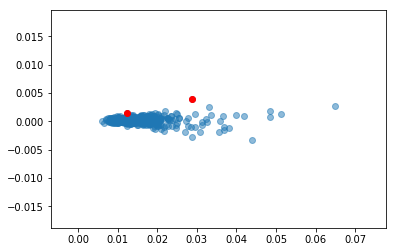

In [12]:
# on récupere les Deux meilleur
res = np.argsort(classement)[-2:]

plt.scatter(std_l,rend_l, alpha=0.5)
plt.scatter(std_l[res],rend_l[res], c="red")

rend: -0.0024873912770831887 & volatilité: 0.011199129719746523 -> poid: [0.45454545 0.54545455]


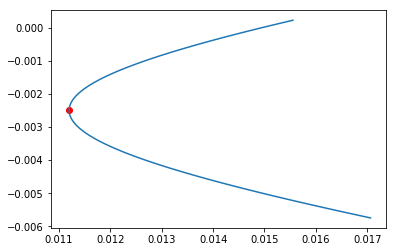

In [13]:
#On créé une matrice avec les rendements de chaque actif en column
mat_return = np.array(l_return.values[res])
mat_return = np.nan_to_num(mat_return)

#On va faire une list de tout les w possible
w = np.linspace(0, 1, num=100)
W = np.array([w, 1-w]).T

variance, std, rend = sharpe(W, mat_return)

#On récupere le minimum de volatilité
minimum = np.argmin(std)
print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {W[minimum]}")

plt.plot(std,rend)
plt.scatter(std[minimum], rend[minimum], c="red")

## Methode Naive à 3 actifs (n=3) 

[111 297 198]


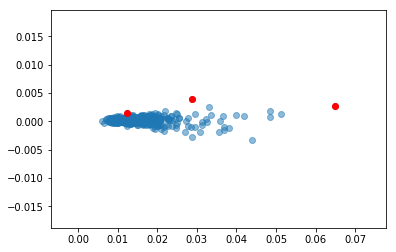

In [14]:
import itertools

w = np.linspace(0, 1, num=100)

n_w = np.array(list(itertools.permutations(w, 3)))

n_w = n_w[np.sum(n_w,axis=1) == 1]

res = np.argsort(classement)[-3:]
print(res)

plt.scatter(std_l,rend_l, alpha=0.5)
plt.scatter(std_l[res],rend_l[res], c="red")

In [15]:
mat_return = np.array(l_return.values[res])
mat_return = np.nan_to_num(mat_return)

variance, std, rend = sharpe(n_w, mat_return)

rend: -0.0038320304174343863 & volatilité: 0.009996056646896087 -> poid: [0.18181818 0.37373737 0.44444444]


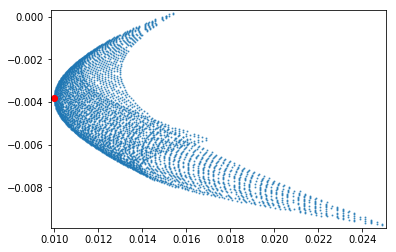

In [16]:
minimum = np.argmin(std)

print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {n_w[minimum]}")

plt.margins(x=0, y=-0.01)
plt.scatter(std,rend,s=1, alpha=0.7)
plt.scatter(std[minimum], rend[minimum], c="red")

# Optimization (minimal var) [avec Resolution analytique]

In [17]:
res = np.argsort(classement)[-2:]
mat_return = np.array(l_return.values[res])


> https://www.ephiquant.com/optimisation-de-portefeuille-modele-mean-variance-de-markowitz/

on cherche a optimiser le programme quadratique suivant

$$ 
 \left\{
    \begin{array}{ll}
       Min \ \sigma^2_p(w) = w^T\sigma w \\
       w^Tu = 1
    \end{array}
\right.$$

on va utiliser la méthode du multiplicateur de Lagrange:

$$
\mathcal{L}(\omega,\lambda) = \omega^\top \sigma \omega - \lambda(\omega^\top u-1)
$$

> où $\lambda$ est le multiplicateur de Lagrange

Nous allons ensuite calculer les dérivées partielles que nous allons spécifier égales à 0 : 

$$
\begin{cases} \frac{\partial\mathcal{L}}{\omega}= 2\sigma\omega-\lambda u=0 \quad \text{(a)}\\  \frac{\partial\mathcal{L}}{\partial\lambda}=\omega^\top u-1=0 \quad\quad\text{(b)}\end{cases}
$$

Nous allons d’abord tirer $\omega$ dans l’équation (a), après quoi nous allons le remplacer dans l’équation (b) par son expression: 

$$
\begin{split} \text{(a)} \quad 2\sigma\omega-\lambda u=0\quad  \implies \omega &= \frac{1}{2}\lambda\sigma^{-1}u \\ \text{(b)} \quad \omega^\top u-1=0 \implies \omega^\top u &= 1 \\ \frac{1}{2}\lambda u^\top\sigma^{-1}u &=1 \\  \lambda &= \frac{2}{u^\top\sigma^{-1}u} \end{split}
$$

Nous allons mettre cette dernière expression de $\lambda$ dans l’expression de $\omega$. Cela donnera ceci : 

$$
\begin{equation*}\omega=\frac{1}{2} \bigg(\frac{2}{u^{\top}\sigma^{-1}u} \bigg) \sigma^{-1}u \implies \omega=\frac{\sigma^{-1}u}{u^\top\sigma^{-1}u} \end{equation*}
$$

In [18]:
# u = [1, ..., 1]

In [19]:
r = rend_l[res]
u = np.ones(r.shape[0])

sigma = np.cov(mat_return)
sigma_inv = np.linalg.inv(sigma) 

w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)
w

array([0.45605329, 0.54394671])

rend: -0.0024873912770831887 & volatilité: 0.011199129719746523 -> poid: [0.45454545 0.54545455]
rend: -0.002496405384735211 & volatilité: 0.011199072859965676 -> poid: [0.45605329 0.54394671]


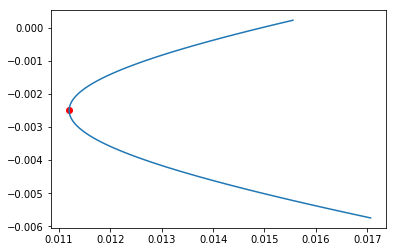

In [20]:
w_ = np.linspace(0, 1, num=100)
W = np.array([w_, 1-w_]).T

variance, std, rend = sharpe(W, mat_return)
minimum = np.argmin(std)
print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {W[minimum]}")

plt.plot(std,rend)

variance, std, rend = sharpe(w, mat_return)
plt.scatter(std, rend, c="red")
print(f"rend: {rend} & volatilité: {std} -> poid: {w}")

## resolution analytique avec les 15 meilleurs actifs

In [21]:
res = np.argsort(classement)[-15:]
r = rend_l[res]
u = np.ones(r.shape[0])
mat_return = np.array(l_return.values[res])

sigma = np.cov(mat_return)

sigma_inv = np.linalg.inv(sigma) 

w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)

w

array([0.07645264, 0.05158086, 0.08992157, 0.0530267 , 0.07518627,
       0.05792779, 0.06952589, 0.08499208, 0.08466267, 0.00972262,
       0.0803148 , 0.0904078 , 0.01016728, 0.07442745, 0.09168357])

In [22]:
variance, std, rend = sharpe(w, mat_return)
print(f"rend: {rend} & volatilité: {std} \n -> poid: {w}")

rend: 0.00029998360940626317 & volatilité: 0.003891647408567846 
 -> poid: [0.07645264 0.05158086 0.08992157 0.0530267  0.07518627 0.05792779
 0.06952589 0.08499208 0.08466267 0.00972262 0.0803148  0.0904078
 0.01016728 0.07442745 0.09168357]


## Benchmark

Regardons l'influence du nombre d'actif sur le rendement et la volatilité.

[2] rend: -0.002496405384735211 & volatilité: 0.011199072859965676
[3] rend: -0.003812778089430599 & volatilité: 0.009995824492435175
[4] rend: -0.001175293296082313 & volatilité: 0.007922907361468725
[5] rend: -0.0015098029623718042 & volatilité: 0.007110939178563843
[6] rend: -0.0012828327480005862 & volatilité: 0.00678191952596989
[7] rend: -0.0017896349072102633 & volatilité: 0.006060112102228489
[8] rend: -0.000507779564527428 & volatilité: 0.005336249204345852
[9] rend: -0.0004433728795026458 & volatilité: 0.004944057182719895
[10] rend: -0.0002021688677221691 & volatilité: 0.004713347831418893
[11] rend: 0.0005290486226837523 & volatilité: 0.004422420638059071
[12] rend: 0.0005342969382620126 & volatilité: 0.004317052143918704
[13] rend: 0.00029344330004148233 & volatilité: 0.004122760748291677
[14] rend: 0.00011698355014283342 & volatilité: 0.004077084619694887
[15] rend: 0.00029998360940626317 & volatilité: 0.003891647408567846
[16] rend: 0.0005134861025407704 & volatilité: 0.

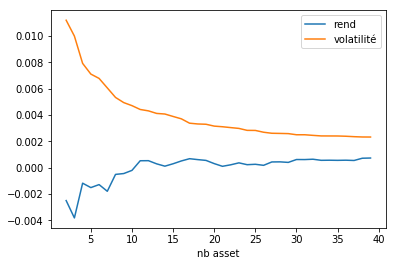

In [23]:
hist = []
for i in range(2,40,1):
    res = np.argsort(classement)[-i:]
    r = rend_l[res]
    u = np.ones(r.shape[0])
    mat_return = np.array(l_return.values[res])

    sigma = np.cov(mat_return)
    sigma_inv = np.linalg.inv(sigma) 

    w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)
    variance, std, rend = sharpe(w, mat_return)
    print(f"[{i}] rend: {rend} & volatilité: {std}")
    hist.append([rend, std])

hist = np.array(hist)

plt.plot(range(2,40,1),hist[:,0], label="rend")
plt.plot(range(2,40,1),hist[:,1], label="volatilité")
plt.xlabel("nb asset")
plt.legend()

## Optimisation avec rendement fixé

In [24]:
res = np.argsort(classement)[-2:]
r = rend_l[res]
u = np.ones(r.shape[0])
mat_return = np.array(l_return.values[res])

sigma = np.cov(mat_return)
sigma_inv = np.linalg.inv(sigma) 

$$
\begin{equation*}\omega=E\mu_0+F\end{equation*}
$$

avec:

$$
E=\frac{1}{D}\sigma^{-1}(C\mu-Au)\quad \text{et} \quad F=\frac{1}{D}\sigma^{-1}(-A\mu+Bu)
$$


Nous allons définir 
- $A=u^\top\sigma^{-1}\mu=\mu^\top\sigma^{-1}u$ 
- $B=\mu^\top\sigma^{-1}\mu$ 
- $C=u^\top\sigma^{-1}u$
- $D=BC-A^2$

In [25]:
A = u.T @ sigma_inv @ r 
B = r.T @ sigma_inv @ r
C = u.T @ sigma_inv @ u
D = B*C - (A**2)

In [26]:
E = (1/D) * sigma_inv @ (C*r - A*u)
F = (1/D) * sigma_inv @ (-A*r + B*u)

w = E* 0.004 + F
w

array([0.99733108, 0.00266892])

In [27]:
variance, std, rend = sharpe(w, mat_return)
print(f"[{i}] rend: {rend} & volatilité: {std}")

[39] rend: -0.005732264675541908 & volatilité: 0.017015748213596516


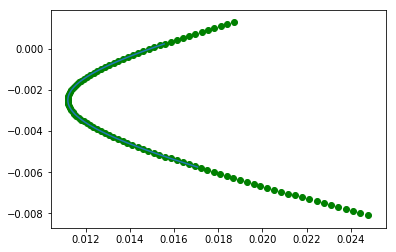

In [28]:
w_ = np.linspace(0, 1, num=100)
W = np.array([w_, 1-w_]).T


variance, std, rend = sharpe(W, mat_return)

minimum = np.argmin(std)
plt.plot(std,rend)

target_ = np.linspace(0.001, 0.005, num=100)
best = ""

for i in target_:
    w = E* i + F
    variance, std, rend = sharpe(w, mat_return)
    if std < rend:
        best = f"rend: {rend} & volatilité: {std}"
        plt.scatter(std, rend, c="red")
    else:
        plt.scatter(std, rend, c="green")
        
print(best)

En Rouge: rendement > risque  
En Vert : rendement < risque

## N=15

In [29]:
res = np.argsort(classement)[-15:]
mat_return = np.array(l_return.values[res])

In [30]:
def get_w(mat_return, u_t= 0.0017):
    r = mat_return.mean(axis=1)
    u = np.ones(r.shape[0])
    
    sigma = np.cov(mat_return)
    sigma_inv = np.linalg.pinv(sigma) 
    
    A = u.T @ sigma_inv @ r 
    B = r.T @ sigma_inv @ r
    C = u.T @ sigma_inv @ u
    D = B*C - (A**2)
    
    E = (1/D) * sigma_inv @ (C*r - A*u)
    F = (1/D) * sigma_inv @ (-A*r + B*u)

    w = E* u_t + F
    return w


w_20 = get_w(mat_return, 0.003)
print(w_20)
sharpe(w_20, mat_return)

[ 0.10376791 -0.00195628  0.05492459  0.05548042  0.14360687  0.08836738
  0.05432981  0.15799963  0.05328932  0.00178605  0.05996284  0.1437077
 -0.040176    0.02969663  0.09521313]


(array(2.29345042e-05), 0.00478899824543687, 0.003)

In [31]:
def checking_w(w):
    if np.sum(w<0) == 0:
        if np.sum((w >= 0.01) & (w <= 0.1)) == w.shape[0]:
            return True
    return False

checking_w(np.array([0.2, 0.05]))

False

In [32]:
import math

sort_ = np.argsort(rend_l/std_l)
classement2 = np.zeros_like(sort_)
for i in range(len(sort_)):
    classement2[sort_[i]] += i
    classement2[sort_rend[i]] += i*0.1

In [33]:
res = np.argsort(classement)[-15:]
mat_return = np.array(l_return.values[res])
target_ = np.linspace(0, 0.1, num=2000)
best = ""
W=np.array([])
actual_rend = 0
actual_std = 1
decal = 0
sharpe_ref = 10000
Res=[]

while decal < 100:
    for j in range(15,16):
        if decal > 0:
            res = np.argsort(classement2)[-j-decal:-decal]
        else:
            res = np.argsort(classement2)[-j:]
        mat_return = np.array(l_return.values[res])
        for i in target_:
            w = get_w(mat_return, i)
            if checking_w(w):
                variance, std, rend = sharpe(w, mat_return)
                print(f"{i:0.3}, {rend:0.6} | {(rend)/std}")
                if sharpe_ref < (rend)/std:
                    Res=res
                    sharpe_ref = (rend)/std
                    W=w
                    actual_rend= rend
                    actual_std = std
                    best = f"rend: {rend} & volatilité: {std}"
                    plt.scatter(std, rend, c="red")
    decal+=1
        
print(best)
W

15 0
0.0, 3.82689e-18 | 1.079469201379398e-15
5e-05, 5.0025e-05 | 0.014136210338853445
0.0001, 0.00010005 | 0.02831540075246581
0.00015, 0.000150075 | 0.042525577051176405
0.0002, 0.0002001 | 0.05675456510142575
0.00025, 0.000250125 | 0.07099006180500457
0.0003, 0.00030015 | 0.08521968757014074
0.00035, 0.000350175 | 0.09943103975978484
0.0004, 0.0004002 | 0.11361174658277436
0.00045, 0.000450225 | 0.12774952088342012
0.0005, 0.00050025 | 0.14183221328477424
0.00055, 0.000550275 | 0.15584786415046906
0.0006, 0.0006003 | 0.16978475384931208
0.00065, 0.000650325 | 0.18363145083528423
0.0007, 0.00070035 | 0.19737685709244615
0.00075, 0.000750375 | 0.21101025053852446
0.0008, 0.0008004 | 0.2245213240314588



array([], dtype=float64)

## Verification

Notre porte-feuille doit respecter plusieurs criteres:

- 50% stock en prix
- check la currency
- check les lots
- 1% a 10% par actif


In [190]:
R_39 = np.array([378,  32, 440, 156, 267, 405, 124, 207, 225, 260, 198, 247, 442, 398, 165, 297, 348, 254])

R_38 = np.array([66, 209, 84, 87, 9, 165, 314, 20, 139, 405, 101, 91, 123, 124, 433, 380, 297, 46])
np.intersect1d(R_39, R_38)

array([124, 165, 297, 405])

In [232]:
test = np.array(dataset)
y = test[:,1]
x = test[:,0]

x_sort = x[np.argsort(y)]
y_sort = y[np.argsort(y)]

# Intersection
res = x_sort[-20:][0]

for i in range(20):
    res = np.intersect1d(res, x_sort[-20:][0])
res

# Union

x = np.concatenate(x_sort[-20:]).ravel()
l_x = np.unique(x, return_counts=True)
res = l_x[0][np.argsort(l_x[1])][-18:]


In [289]:
mat_return = np.array(l_return.values[R_39])
ww = get_w(mat_return, 7.491159385517032e-18)
ariance, std, rend = sharpe(ww, mat_return)
new_pt = get_asset_pf(ww, l_id[R_39], list_nav)
print(new_pt)

new_portfolio = {
                "label":"EPITA_PTF_8",
                "currency": {
                    "code":"EUR"
                },
                "type":"front",
                "values": {
                    "2016-06-01": new_pt
                }
            }
ppp = json.dumps(new_portfolio)
for azerty in range(3):
    time.sleep(1)
    req.push(ppp).text
sharpe_ = float(json.loads(req.get_ratios())["1827"]["12"]["value"].replace(",", "."))
print(sharpe_)

print(ww)
checking_w(ww)

Stock % :0.71
id: 1590, 0.0404% du global, nb: 156588, unit: 25.8, price: 4039970.4 EUR
id: 1858, 0.0616% du global, nb: 169837, unit: 36.29, price: 6163384.7299999995 EUR
id: 1764, 0.0356% du global, nb: 31230, unit: 113.9, price: 3557097.0 EUR
id: 1931, 0.0282% du global, nb: 26871, unit: 105.0, price: 2821455.0 EUR
id: 1504, 0.0607% du global, nb: 20318, unit: 298.65, price: 6067970.699999999 EUR
id: 1623, 0.0493% du global, nb: 18011, unit: 273.45, price: 4925107.95 EUR
id: 1910, 0.058% du global, nb: 93566, unit: 62.0, price: 5801092.0 EUR
id: 1965, 0.0971% du global, nb: 72145, unit: 134.5, price: 9703502.5 EUR
id: 1973, 0.0845% du global, nb: 2101328, unit: 4.02, price: 8447338.559999999 EUR
id: 2000, 0.0878% du global, nb: 349591, unit: 25.1, price: 8774734.1 EUR
id: 1958, 0.0886% du global, nb: 60673, unit: 145.95, price: 8855224.35 EUR
id: 1987, 0.0407% du global, nb: 329314, unit: 12.355, price: 4068674.47 EUR
id: 2120, 0.029% du global, nb: 1002, unit: 2892.0, price: 289778

True

In [233]:
import time

best= 0
PP  = ""
#Res = np.array([469, 32, 435, 354, 254, 309, 282, 139, 260, 267, 165, 442, 49, 338, 156, 123, 93, 351])
#Res =np.array([469, 158, 250, 217, 9, 209, 201, 297, 269, 392, 463, 101, 300, 237, 440, 267, 46, 313])
mat_return = np.array(l_return.values[res])
target_ = np.linspace(-0.1, 0.001, num=10000)

for i in target_:
    ww = get_w(mat_return, i)
    if checking_w(ww):
        variance, std, rend = sharpe(ww, mat_return)
        new_pt = get_asset_pf(ww, l_id[res], list_nav)
        new_portfolio = {
                "label":"EPITA_PTF_8",
                "currency": {
                    "code":"EUR"
                },
                "type":"front",
                "values": {
                    "2016-06-01": new_pt
                }
            }
        ppp = json.dumps(new_portfolio)
        for azerty in range(3):
            time.sleep(1)
            req.push(ppp).text
        sharpe_ = float(json.loads(req.get_ratios())["1827"]["12"]["value"].replace(",", "."))
        print(f"{i}, {rend}")
        print(sharpe_)
        if best < sharpe_:
            PP = ppp
            best = sharpe_

% de chaque actif : [0.04649611 0.05866689 0.02466263 0.03449888 0.08924772 0.07363554
 0.05275441 0.066499   0.01981447 0.04335117 0.09999728 0.05379814
 0.04258966 0.02766222 0.06085595 0.08822388 0.03668218 0.08056388]
Stock % :0.62
-0.0006262626262626275, -0.0006262626262626284
2.911165358793
% de chaque actif : [0.04648297 0.05871186 0.02476114 0.03453273 0.08924322 0.07373888
 0.0528119  0.06651171 0.0199656  0.04324726 0.09988893 0.05372254
 0.04277088 0.02763377 0.06093655 0.08796737 0.03663735 0.08043535]
Stock % :0.62
-0.0006161616161616118, -0.0006161616161616125
2.911264284333
% de chaque actif : [0.04647164 0.05875938 0.02486051 0.03456809 0.0892426  0.07384534
 0.05287161 0.06652877 0.02011759 0.04314427 0.09978498 0.05365076
 0.04290811 0.02760652 0.06101979 0.08771471 0.03659411 0.08031122]
Stock % :0.62
-0.00060606060606061, -0.0006060606060606106
2.911377530503
% de chaque actif : [0.04646045 0.0588068  0.02496005 0.03460338 0.08924183 0.07395176
 0.05293131 0.0665457

KeyboardInterrupt: 

In [104]:
best

3.395504991613

In [35]:
def check_type(list_id):
    #df_asset = req.get_asset()[["ASSET_DATABASE_ID", "TYPE"]]
    mask = df_asset['ASSET_DATABASE_ID'].isin(list_id)
    pf_type = df_asset.loc[mask]["TYPE"].values
    #print(np.unique(pf_type, return_counts=True))
    return pf_type
    
    
check_type(l_id[Res])

array(['FUND', 'STOCK', 'STOCK', 'INDEX', 'STOCK', 'STOCK', 'FUND',
       'STOCK', 'STOCK', 'FUND', 'STOCK', 'STOCK', 'FUND', 'STOCK',
       'INDEX', 'STOCK', 'STOCK', 'STOCK'], dtype=object)

In [36]:
def check_currency(list_id):
    mask = df_asset['ASSET_DATABASE_ID'].isin(list_id)
    pf_type = df_asset.loc[mask]["CURRENCY"].values
    return pf_type

check_currency(l_id[Res])

array(['USD', 'EUR', 'EUR', 'EUR', 'USD', 'EUR', 'EUR', 'EUR', 'EUR',
       'EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'USD', 'EUR', 'EUR', 'USD'],
      dtype=object)

In [ ]:
req.change_currency("USD","EUR")

In [288]:
def get_amout(w, list_id, list_nav, solde= 100000000):
    
    stock_price = 0
    global_price = 0
    actif_price = []
    unit_price_l = []
    
    #On recupere la list de type d'actif et leur currency
    l_currency = check_currency(list_id)
    l_type = check_type(list_id)
    
    if l_currency.shape[0] != list_id.shape[0]:
        print("CHELOU:", l_currency.shape, list_id.shape)
    
    #On prend les prix de l'actif a la date
    start = dt.datetime.strptime('2016-06-01', '%Y-%m-%d')
    price = list_nav.loc[list_nav.index == start]
    
    #Pour chaque actif on recupere le nombre que l'on peut en acheter
    # nombre = (solde*poid) / prix d'une action
    nb_actif= []
    for i in range(len(list_id)):
        unit_price = price[list_id[i]].values[0]
        if l_currency[i] != "EUR":
            r = req.change_currency(l_currency[i],"EUR")
            unit_price = r * unit_price
            
        nb = int((solde*w[i])//unit_price)
        
        if l_type[i] == "STOCK":
            stock_price+= nb*unit_price
        global_price += nb*unit_price
        
        unit_price_l.append(unit_price)
        nb_actif.append(nb)
        actif_price.append(nb*unit_price)
        
    actif_price = np.array(actif_price)
    #print("% de chaque actif :",actif_price/global_price)
    print(f"Stock % :{(stock_price/global_price):0.2}")
    tmp = actif_price/global_price
    for i in range(len(list_id)):
        print(f"id: {list_id[i]}, {tmp[i]:0.3}% du global, nb: {nb_actif[i]}, unit: {unit_price_l[i]}, price: {actif_price[i]} {l_currency[i]}")
    return np.array(nb_actif)
    
    
get_amout(W, l_id[Res], list_nav)

Stock % :0.59
id: 1591, 0.0573% du global, nb: 39219, unit: 146.2, price: 5733817.8 EUR
id: 2112, 0.0622% du global, nb: 148499, unit: 41.89189189188689, price: 6220904.054053311 USD
id: 2077, 0.0149% du global, nb: 25267, unit: 59.08, price: 1492774.3599999999 EUR
id: 1519, 0.0387% du global, nb: 27445, unit: 140.825381, price: 3864952.581545 EUR
id: 1444, 0.0334% du global, nb: 90081, unit: 37.11294075532043, price: 3343170.8161800196 USD
id: 2000, 0.0741% du global, nb: 295156, unit: 25.1, price: 7408415.600000001 EUR
id: 1515, 0.0383% du global, nb: 23044, unit: 166.1328, price: 3828364.2432 EUR
id: 1484, 0.078% du global, nb: 19355, unit: 402.93, price: 7798710.15 EUR
id: 1541, 0.0726% du global, nb: 4232, unit: 1715.05, price: 7258091.6 EUR
id: 2058, 0.0509% du global, nb: 234948, unit: 21.65, price: 5086624.199999999 EUR
id: 1965, 0.0879% du global, nb: 72988, unit: 120.3687130839305, price: 8785471.63056992 USD
id: 2023, 0.0285% du global, nb: 6797439, unit: 0.42, price: 285492

array([  39219,  148499,   25267,   27445,   90081,  295156,   23044,
         19355,    4232,  234948,   72988, 6797439,    1407,  308743,
       1082390,  995473,  265763,   68375])

Nous verrifions si le montant de stock est bien superieur a 50%

In [38]:
def get_asset_pf(W, list_id, list_nav):
    nb = get_amout(W,list_id,list_nav)
    nb = np.nan_to_num(nb)
    ret = []
    for i in range(len(list_id)):
        js = {}
        js["asset"] = int(list_id[i])
        js["quantity"] = int(nb[i])
        ret.append({"asset": js})
    return ret

new_pt = get_asset_pf(W, l_id[Res], list_nav)
new_pt

[{'asset': {'asset': 2106, 'quantity': 82742}},
 {'asset': {'asset': 2165, 'quantity': 224}},
 {'asset': {'asset': 1989, 'quantity': 826854}},
 {'asset': {'asset': 1485, 'quantity': 68}},
 {'asset': {'asset': 2154, 'quantity': 125673}},
 {'asset': {'asset': 1966, 'quantity': 874890}},
 {'asset': {'asset': 2082, 'quantity': 331343}},
 {'asset': {'asset': 2024, 'quantity': 57527}},
 {'asset': {'asset': 1507, 'quantity': 500503}},
 {'asset': {'asset': 1608, 'quantity': 19895}},
 {'asset': {'asset': 1940, 'quantity': 1093131}},
 {'asset': {'asset': 1892, 'quantity': 311411}},
 {'asset': {'asset': 1538, 'quantity': 137987}},
 {'asset': {'asset': 1591, 'quantity': 35007}},
 {'asset': {'asset': 1764, 'quantity': 16187}},
 {'asset': {'asset': 1504, 'quantity': 17183}},
 {'asset': {'asset': 1864, 'quantity': 70078}},
 {'asset': {'asset': 2034, 'quantity': 569900}}]

In [39]:
dataset = []

In [132]:
print(np.max(np.array(dataset), axis=0))
print(len(dataset))

[list([469, 165, 251, 424, 46, 422, 433, 138, 123, 303, 402, 237, 348, 93, 396, 124, 392, 68])
 3.378973029611]
273


In [235]:
import time
import random

sort_ = np.argsort(rend_l/std_l)
classement2 = np.zeros_like(sort_)
for i in range(len(sort_)):
    classement2[sort_[i]] += i
    classement2[sort_rend[i]] += i*0.1

res = np.argsort(classement)[-15:]
mat_return = np.array(l_return.values[res])
target_ = np.linspace(0, 0.01, num=100)
best = ""
W=np.array([])
decal = 0
sharpe_ref = -10000
Res=[]
best_sharpe = 0

while decal < 1000:
    res = random.sample(list(l_x[0]),k=18)#list(np.argsort(classement2)[-100:]), k=18)
    mat_return = np.array(l_return.values[res])

    try:
        w = get_w(mat_return, target_[0])
        if checking_w(w):
            variance, std, rend = sharpe(w, mat_return)
            print(f"{rend:0.6} | {(rend)/std}")

            new_pt = get_asset_pf(w, l_id[res], list_nav)
            new_portfolio = {
                "label":"EPITA_PTF_8",
                "currency": {
                    "code":"EUR"
                },
                "type":"front",
                "values": {
                    "2016-06-01": new_pt
                }
            }
            pp = json.dumps(new_portfolio)
            for azerty in range(3):
                time.sleep(1)
                req.push(pp).text
            sharpe_ = float(json.loads(req.get_ratios())["1827"]["12"]["value"].replace(",", "."))
            print("res: ",sharpe_)
            dataset.append([res,sharpe_])
            if sharpe_ > best_sharpe:
                print("##########RES: ",sharpe_)
                best = f"rend: {rend} & volatilité: {std} , {sharpe_}"
                PP = pp
                best_sharpe = sharpe_
                W=w
                Res=res

    except:
        pass
    decal+=1
        
print(best)
W

-1.11131e-18 | -2.8795681860005586e-16
% de chaque actif : [0.05791952 0.08724732 0.05312586 0.04542288 0.0789493  0.02998297
 0.08988739 0.04767641 0.03582228 0.040076   0.08534428 0.01607189
 0.09600414 0.03428072 0.04286414 0.06100903 0.02852646 0.06978943]
Stock % :0.48
res:  1.29764913493
##########RES:  1.29764913493
-9.30889e-19 | -2.522254354892386e-16
% de chaque actif : [0.0972606  0.06525317 0.0551973  0.09683229 0.04391872 0.02175191
 0.03697676 0.04624828 0.07188745 0.06287166 0.05483685 0.04097804
 0.0639823  0.04225304 0.07799738 0.03540983 0.05637067 0.02997375]
Stock % :0.71
res:  1.434349356549
##########RES:  1.434349356549
-5.40746e-18 | -1.414728260308383e-15
% de chaque actif : [0.09750574 0.05772082 0.08160562 0.05325305 0.04216229 0.05550863
 0.07401711 0.02140983 0.08610581 0.04206916 0.08077102 0.02530753
 0.04819655 0.04515149 0.08284806 0.01733918 0.04714702 0.04188109]
Stock % :0.69
res:  2.419672611133
##########RES:  2.419672611133
-2.08709e-18 | -6.60023

res:  1.926905157794
5.42101e-19 | 1.6076336417763852e-16
% de chaque actif : [0.05753013 0.01352637 0.07123119 0.0670553  0.03295059 0.08429665
 0.05702876 0.05319627 0.08156221 0.04259174 0.01905687 0.04954778
 0.05939863 0.07209581 0.04365754 0.0342528  0.09729933 0.06372203]
Stock % :0.66
res:  0.866488979855
-1.3146e-18 | -4.13038311917195e-16
% de chaque actif : [0.09570023 0.01731559 0.05057338 0.03105474 0.06617903 0.03784446
 0.0623585  0.05106426 0.05581925 0.08926885 0.06500936 0.07463531
 0.0449445  0.06698826 0.07110296 0.04857    0.03908695 0.03248436]
Stock % :0.67
res:  0.865505406758
1.02999e-18 | 3.0011787186387447e-16
% de chaque actif : [0.06939131 0.09855903 0.06965033 0.09998469 0.02755275 0.04543631
 0.05481031 0.03283397 0.05909487 0.06186491 0.04242642 0.05443757
 0.0224041  0.04978809 0.06553943 0.057531   0.04864108 0.04005382]
Stock % :0.64
res:  0.103998607969
-6.64074e-19 | -1.8544554611016844e-16
% de chaque actif : [0.03810732 0.07984608 0.0751453  0.027

array([0.05733906, 0.0622091 , 0.01492792, 0.03865056, 0.03343194,
       0.07408417, 0.03828506, 0.07798782, 0.07258643, 0.05086625,
       0.08785489, 0.02854925, 0.02954195, 0.08908781, 0.05011468,
       0.07537724, 0.05791429, 0.06119158])

## Porte-Feuille

In [52]:
new_portfolio = {
    "label":"EPITA_PTF_8",
    "currency": {
        "code":"EUR"
    },
    "type":"front",
    "values": {
        "2016-06-01": new_pt
    }
}
pp = json.dumps(new_portfolio)
#with open('data2.txt', 'w') as outfile:
#    json.dump(new_portfolio, outfile)

In [274]:
req.push(pp39).text

''

In [276]:
#9:r 10:v 12:sharpe 3.284743012218'
pd.DataFrame(json.loads(req.get_ratios()))

,2201,1827
10,"{'type': 'percent', 'value': '0,166459552501'}","{'type': 'percent', 'value': '0,373605296016'}"
12,"{'type': 'double', 'value': '0,146571943186'}","{'type': 'double', 'value': '3,395504991613'}"
9,"{'type': 'percent', 'value': '0,029398300072'}","{'type': 'percent', 'value': '1,273578647515'}"


In [244]:
pd.DataFrame(json.loads(req.get_ratios()))

,2201,1827
10,"{'type': 'percent', 'value': '0,166459552501'}","{'type': 'percent', 'value': '0,373605296016'}"
12,"{'type': 'double', 'value': '0,146571943186'}","{'type': 'double', 'value': '3,395504991613'}"
9,"{'type': 'percent', 'value': '0,029398300072'}","{'type': 'percent', 'value': '1,273578647515'}"


In [112]:
# 3.17
pp1 = PP

f = open("3_39.txt", "w")
f.write(pp1)
f.close()
pp1

'{"label": "EPITA_PTF_8", "currency": {"code": "EUR"}, "type": "front", "values": {"2016-06-01": [{"asset": {"asset": 1590, "quantity": 152865}}, {"asset": {"asset": 1858, "quantity": 165185}}, {"asset": {"asset": 1764, "quantity": 32318}}, {"asset": {"asset": 1931, "quantity": 26270}}, {"asset": {"asset": 1504, "quantity": 19240}}, {"asset": {"asset": 1623, "quantity": 17725}}, {"asset": {"asset": 1910, "quantity": 91970}}, {"asset": {"asset": 1965, "quantity": 74200}}, {"asset": {"asset": 1973, "quantity": 2278747}}, {"asset": {"asset": 2000, "quantity": 351614}}, {"asset": {"asset": 1958, "quantity": 61367}}, {"asset": {"asset": 1987, "quantity": 308628}}, {"asset": {"asset": 2120, "quantity": 1103}}, {"asset": {"asset": 2194, "quantity": 1704}}, {"asset": {"asset": 2172, "quantity": 95}}, {"asset": {"asset": 2024, "quantity": 6335977}}, {"asset": {"asset": 2185, "quantity": 6450}}, {"asset": {"asset": 1995, "quantity": 6534923}}]}}'

In [267]:
# best avec 2.7
with open('3_37.txt') as json_file:
    data = json.load(json_file)
data
pp37 = str(data)

with open('3_39.txt') as json_file:
    data = json.load(json_file)
data
pp39 = str(data)

with open('3_28.txt') as json_file:
    data = json.load(json_file)
data
pp28 = str(data)